<h1><center>Rozpoznawanie liter języka migowego</center></h1>
<h2><center>Głębokie sieci neuronowe</center></h2>
<p>
<h3><right>Przygotowali: Piotr Kozub, Olivier Kroll</right></h3>
<h3><right>Prowadzący: Dr hab. inż. Andrzej Rusiecki</center></h3>                                                                           <h4><right>Data: 16.01.2023</right></h4>

Celem naszego projektu jest stworzenie głębokiej sieci neuronowej służacej do rozpoznawania liter języka migowego. W tym celu wykorzystaliśmy zbiór danych dostępny na stronie kaggle.com. Posiada on ponad 27 tysięcy obrazów treningowych oraz 7 tysięcy obrazów testowych zapisanych do pliku csv. Każde zdjęcie posiada 784 piksele (28x28) reprezentowane w skali szarości z zakesu 0-255.

Zbiór danych posiada 24 klasy odpowiadające poszczególnym literom alfabetu. W projekcie nie uwzględniamy litery "J" oraz "Z", ponieważ zasada ich wizualizacji polega na dynamicznym ruchu ręką.

### Wykorzystywane litery języka migowego:

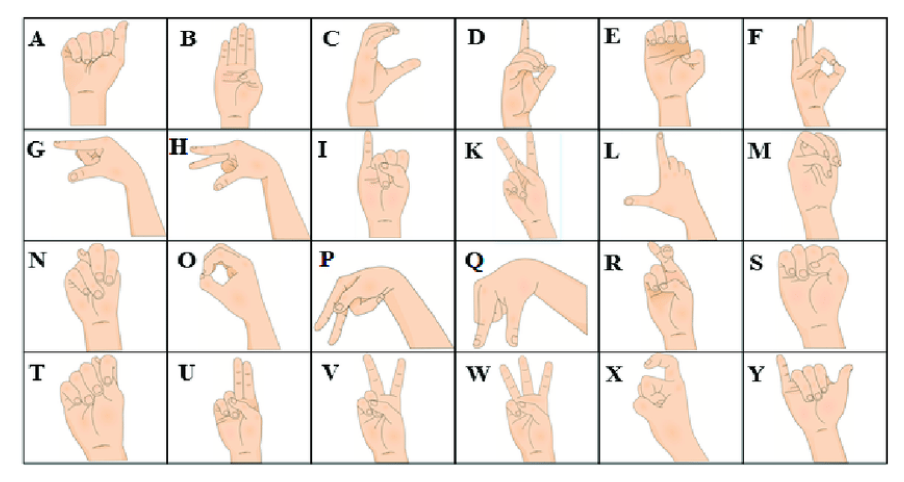

In [32]:
plt.figure(figsize = (12,6))
plt.imshow(img, cmap='gray')
plt.axis('off');

### 1. Pobranie zbioru danych
Na początku pobieramy dane z plików csv. Wszystkie obrazy mają 785 kolumn danych, gdzie pierwsza z nich odpowiada za etykietę, zaś wszystkie kolejne to wartości pikseli.

In [2]:
train_df=pd.read_csv('kaggle\sign_mnist_train.csv')
test_df=pd.read_csv('kaggle\sign_mnist_test.csv')

In [4]:
train_df

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,...,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,...,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,...,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,...,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,...,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,...,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,...,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,...,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,...,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,...,27,58,102,79,47,64,87,93


Etykiety naszego zbioru to liczby od 0 do 24 z pominięciem cyfry 9 odpowiedzialnej za nieuwzględnianą w projekcie literę "J".

In [5]:
df = train_df.iloc[:,0]
print(df.unique())

[ 3  6  2 13 16  8 22 18 10 20 17 19 21 23 24  1 12 11 15  4  0  5  7 14]


### 2. Dodanie własnego znaku
Po załadowaniu zbioru danych przechodzimy do powiększenia go o nowy znak symbolizujący powiedzenie "I Love You". W tym celu wykonaliśmy 150 zdjęć naszych dłoni ułożonych w ten sam sposób. Nowe obrazu dzielimy w taki sposób by 110 z nich należało do zbioru treningowego, a 40 do testowego. Wszystkie zdjęcia konwertujemy do skali szarości oraz rozmiaru odpowiadającemu pozastałym danym. Jako etykiete wykorzystujemy brakującą cyfrę 9.

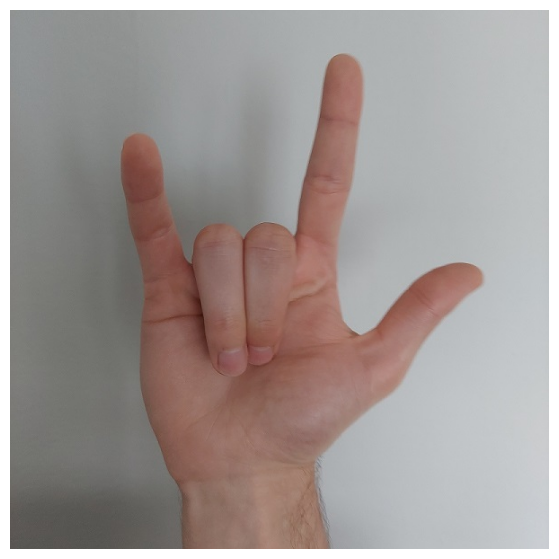

In [37]:
plt.figure(figsize = (14,7))
plt.imshow(img, cmap='gray')
plt.axis('off');

### 3. Konwertowanie danych
Kolejnym krokiem jest przekonwertowanie danych do formy wymaganej na wejściu sieci neuronowej. W tym celu oddzielamy etykiety od obrazków do osobnych dataframów. Następnie zmieniamy jednowymiarowy ciąg pikseli na macierz o wymiarze 28x28 (przejście z 1D na 3D). 

In [14]:
train_label=train_df['label']
trainset=train_df.drop(['label'],axis=1)
trainset.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,...,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,...,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,...,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,...,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,...,105,108,133,163,157,163,164,179


In [15]:
X_train = trainset.values
X_train = trainset.values.reshape(-1,28,28,1)
print(X_train.shape)

(27565, 28, 28, 1)


In [16]:
test_label=test_df['label']
X_test=test_df.drop(['label'],axis=1)
X_test=X_test.values.reshape(-1,28,28,1)
print(X_test.shape)

(7212, 28, 28, 1)


Dotychczaswo nasze etykiety miały formę kolejnych liczb naturalnych od 0 do 24. Jedną z możliwości jest przetransformowanie ich do zmiennych kategorycznych (one-hot encoding). Od teraz każda etykieta przybierze postać ciagu 25 liczb, gdzie tylko jedna z nich będzie równa 1, zaś reszta to 0. Numer miejsca, w którym zapisana zostanie cyfra 1, oznaczać będzie klasę zdjęcia, np. jeśli y = 4, to tablica = [0 0 0 1 0 0.....0].

In [17]:
lb=LabelBinarizer()
y_train=lb.fit_transform(train_label)
y_test=lb.fit_transform(test_label)
y_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Ostateczne rozmiary przygotowanych zbiorów:

In [18]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(27565, 28, 28, 1) (27565, 25) (7212, 28, 28, 1) (7212, 25)


### 5. Przegląd zbioru danych

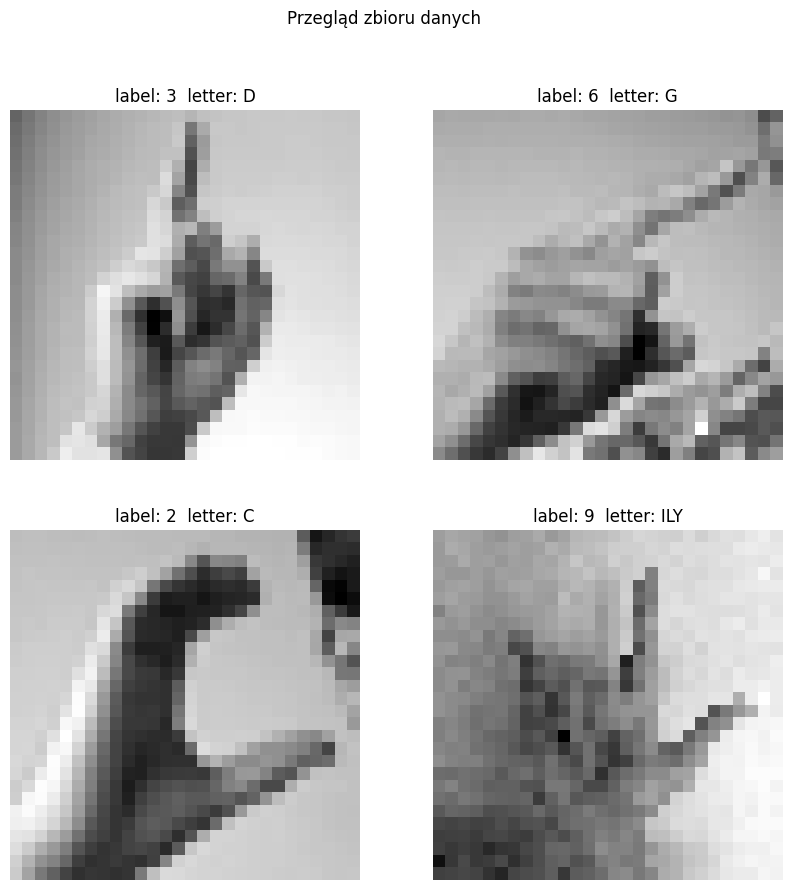

In [19]:
fig,axe=plt.subplots(2,2,figsize = (10,10))
axe[0,0].imshow(X_train[0].reshape(28,28),cmap='gray')
axe[0,0].set_title('label: 3  letter: D')
axe[0,0].axis('off')
axe[0,1].imshow(X_train[1].reshape(28,28),cmap='gray')
axe[0,1].set_title('label: 6  letter: G')
axe[0,1].axis('off')
axe[1,0].imshow(X_train[2].reshape(28,28),cmap='gray')
axe[1,0].set_title('label: 2  letter: C')
axe[1,0].axis('off')
axe[1,1].imshow(X_train[27462].reshape(28,28),cmap='gray')
axe[1,1].set_title('label: 9  letter: ILY')
axe[1,1].axis('off')
fig.suptitle('Przegląd zbioru danych', fontsize=12);

Powyższe obrazki przedstawiają rzeczywisty wygląd danych, jakie będą wykorzystywały przygotowane modele sieci neuronowych. Można zaobserwować, że zdjęcia zapisane w zbiorze MNIST zostały poddane pewnemu preprocessingowi. Nie widać na nich szumów, tło jest jednolite, a obrys dłoni wyraźny pomimo niskiej rozdzielczości. Tego samego nie można powiedzieć o zdjęciu wykonanym przez nas. Zmniejszenie rozdzielczości spowodowało, że obraz stał się zaszumiony. Dłoń pozostała widoczna, jednak jej obrys mocno zlewa się z nierównomiernym tłem.

Przedstawienie histogramów zbioru danych:

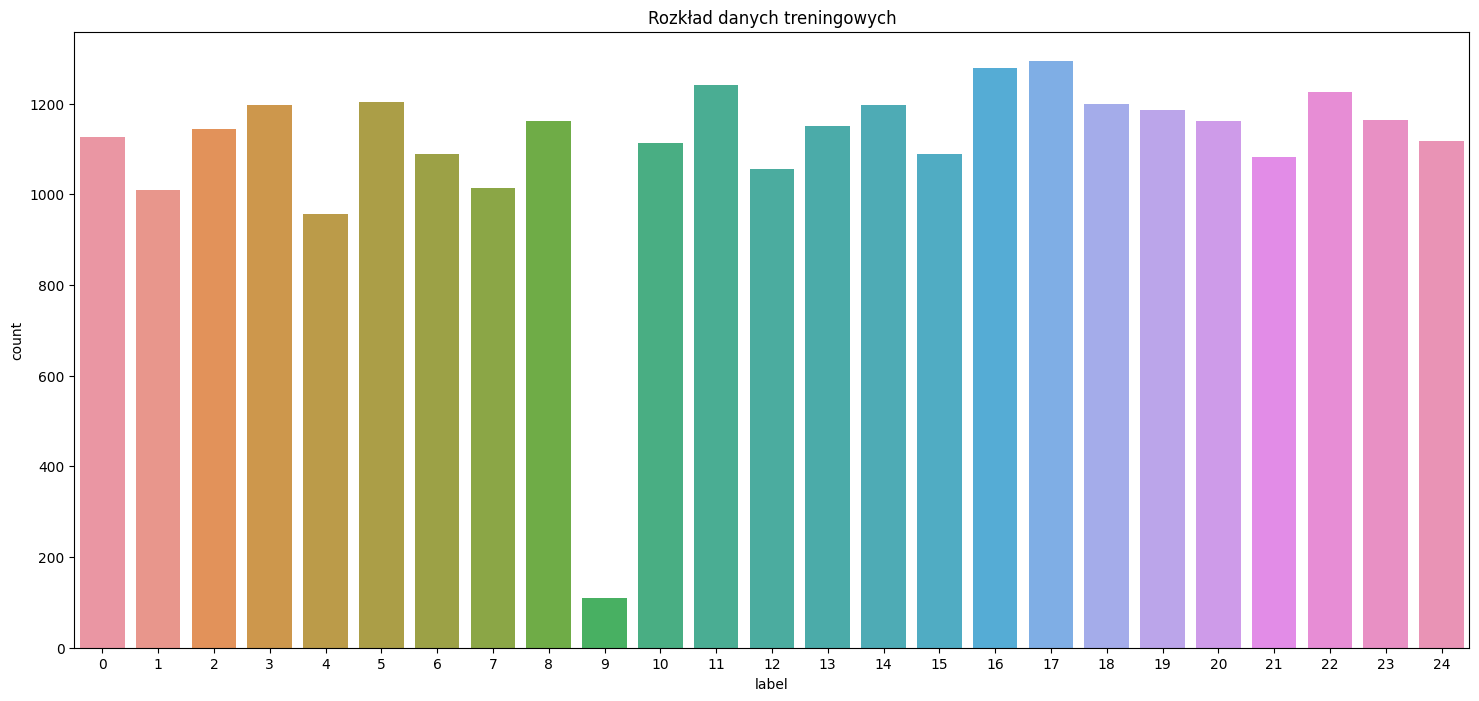

In [20]:
plt.figure(figsize = (18,8))
sns.countplot(x=train_label)
plt.title("Rozkład danych treningowych");

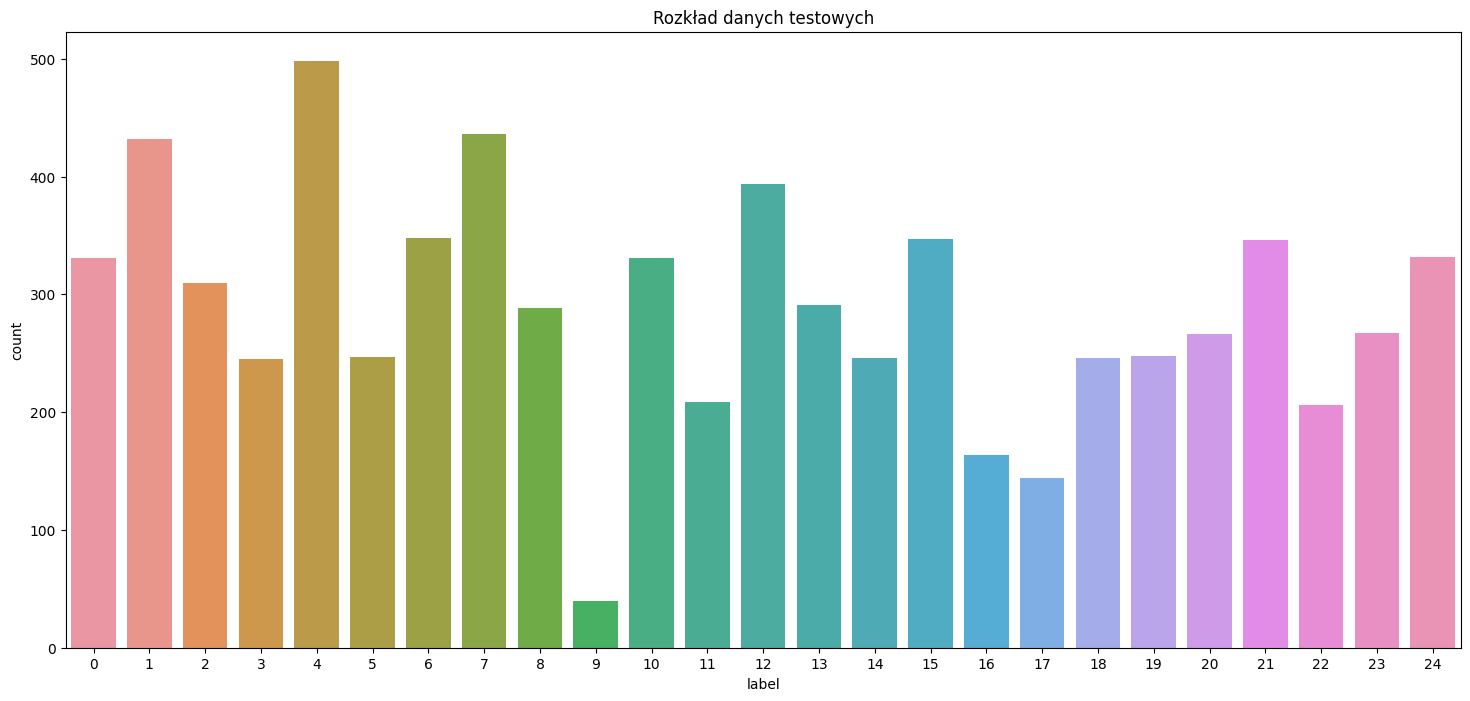

In [21]:
plt.figure(figsize = (18,8))
sns.countplot(x=test_label)
plt.title("Rozkład danych testowych");

Rozkład danych treningowych jest praktycznie równomierny, dlatego nie ma potrzeby na zastosowanie over/undersamplingu. Dane testowe nie są już tak idealne, jednak nie wpływają one w żadnym stopniu na proces uczenia. Klasa 9 jest zdecydowanie najmniej liczna, gdyż reprezentuje ona nasz własny znak. Wyrównanie histogramu wymagałoby w tym przypadku znacznie większego nakładu czasu poświeconego na przygotowanie zdjęć.

### 6. Stworzenie pierwszego modelu jednokierunkowej sieci neuronowej

Etap przygotowania modelu szucznej inteligencji rozpocznie się od stworzenia najprostszej jednokierunkowej sieci neuronowej. Jej celem jest wyznaczenie pewnego punktu odniesienia, dzięki któremu będzie można porównać uczenie płytkie z głębokim.
Przygotowana sieć składa się z:
- warstwy wejściowej - 784 neurony
- warstwy ukrytej - 256 neuronów
- warstwy wyjściowej - 25 neuronów

In [22]:
model = Sequential()
model.add(Flatten())
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=25,activation='softmax'))

In [23]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [24]:
history = model.fit(X_train,y_train,batch_size=64, verbose=0,
                    epochs = 10, validation_data=(X_test, y_test))

model.save("ANN_Model.h5")

In [25]:
model = tf.keras.models.load_model("ANN_Model.h5")

In [26]:
(ls,acc)=model.evaluate(x=X_test,y=y_test)

226/226 [==============================] - 1s 2ms/step - loss: 2.8713 - accuracy: 0.0793


In [27]:
print('Skuteczność modelu na zbiorze testowym = {:.2f}%'.format(acc*100))

Skuteczność modelu na zbiorze testowym = 7.93%


Skuteczność sieci jednokiernkowej bez ekstrakcji cech wykonanej przez warstwy konwolucyjne okazała się znikoma. Sieć nie jest w stanie nauczyć się przygotowanego zbioru nawet w najmniejszym stopniu i jest nieznacznie lepsza od zgadywania (Szansa na losowe zgadnięcie poprawnej odpowiedzi przy 25 klasach wynosi 4%). 

### 7. Stworzenie modelu konwolucyjnej sieci neuronowej

Wykorzystany model sieci konwolucyjnej będzie składał się z trzech warstw splotu oraz dwóch warst poolingu.
Początkowy obrazek o wymiarze 28x28 przechodzi następującą transformację:
- 32 filtry o rozmiarze 28x28 (okno 3x3)
- MaxPooling zmniejszający rozmiar filtrów dwukrotnie (okno 2x2)
- 64 filtry o rozmiarze 14x14 (okno 3x3)
- MaxPooling zmniejszający rozmiar filtrów dwukrotnie (okno 2x2)
- 64 filtry o rozmiarze 7x7 (okno 3x3)

W trakcie splotu nie tracimy krawędzi zdjęcia dzięki zastosowaniu paddingu. Po wymnożeniu otrzymujemy 3136 neurony na wejściu do sieci jednokierunkowej.
Przed warstwą wyjściową składającą się z 25 neuronów (odpowiadającym liczbie klas), dodaliśmy jedną warstwę ukrytą o rozmiarze 256 neuronów. Dodatkowo losowo dezaktywujemy 1/4 neuronów w trakcie uczenia, w celu uniknięcia overfittingu.

In [28]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(MaxPool2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Flatten())
model.add(Dense(units=256,activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(units=25,activation='softmax'))

In [29]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [30]:
history_cnn = model.fit(X_train,y_train,batch_size=64, verbose=0,
                        epochs = 10, validation_data=(X_test, y_test))

model.save("CNN_Model.h5")

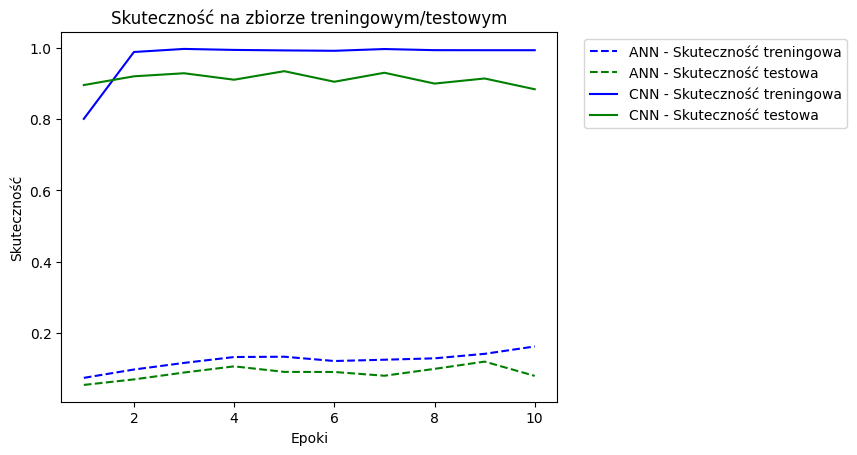

In [31]:
epochs = range(1,11)
plt.plot(epochs, history.history['accuracy'], 'b', linestyle='dashed', label='ANN - Skuteczność treningowa')
plt.plot(epochs, history.history['val_accuracy'], 'g', linestyle='dashed', label='ANN - Skuteczność testowa')
plt.plot(epochs, history_cnn.history['accuracy'], 'b', label='CNN - Skuteczność treningowa')
plt.plot(epochs, history_cnn.history['val_accuracy'], 'g', label='CNN - Skuteczność testowa')
plt.title('Skuteczność na zbiorze treningowym/testowym')
plt.xlabel('Epoki')
plt.ylabel('Skuteczność')
plt.legend(bbox_to_anchor=(1.04, 1))
plt.show()

In [32]:
model = tf.keras.models.load_model("CNN_Model.h5")

In [33]:
(ls,acc)=model.evaluate(x=X_test,y=y_test)

226/226 [==============================] - 1s 6ms/step - loss: 0.7174 - accuracy: 0.8841


In [34]:
print('Skuteczność modelu na zbiorze testowym = {:.2f}%'.format(acc*100))

Skuteczność modelu na zbiorze testowym = 88.41%


Jak możemy zauważyć sieć bardzo szybko uczy się trafnie rozpoznawać obrazy treningowe. Już po trzecim przejściu przez zbiór uzyskujemy skuteczność przekaczającą 99%. Niestety skuteczność na zbiorze testowym osiąga niewiele ponad 88%. Oznacza to, że pomimo zastosowania dropoutu sieć ulega przeuczuniu. 

Podczas realizacji projektu sprawdziliśmy wiele różnych architerktur sieci konwulucyjnych. Zmiany ilości filtrów, poolingu, rozmiarów ich okien czy też większego dropoutu za każdym razem kończyły się wynikiem z zakresu 80-90%. Sposobu na zwiększenie skuteczności modelu należy zatem szukać w ewentualnych modyfikacjach zbioru danych.

### 8. Modyfikacja zbioru danych
Pakiet ImageDataGenerator z pakietu keras.preprocessing.image umożliwia dodawanie różnych zniekształceń do zbioru obrazów poprzez zapewnienie losowego obracania, powiększania/pomniejszania, skalowania wysokości lub szerokości itp.
Zestaw danych obrazu jest tutaj również znormalizowany przy użyciu parametru rescale, który dzieli każdy piksel przez 255, tak że wartości pikseli mieszczą się w zakresie od 0 do 1.

Dodatkowo dane testowe są także są normalizowane jednak nie zastowaliśmy na nich operacji rozszerzania zbioru.

In [35]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range = 0,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  shear_range=0,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

X_test=X_test/255

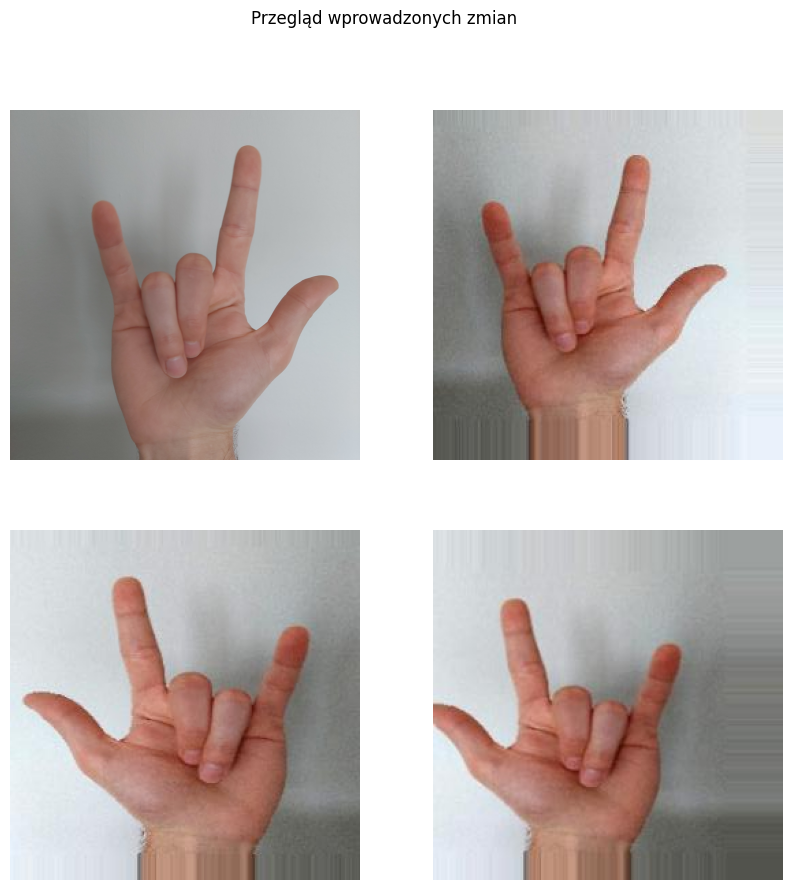

In [36]:
fig,axe=plt.subplots(2,2,figsize = (10,10))
axe[0,0].imshow(org_example,cmap='gray')
axe[0,0].axis('off')
axe[0,1].imshow(examples[0],cmap='gray')
axe[0,1].axis('off')
axe[1,0].imshow(examples[1],cmap='gray')
axe[1,0].axis('off')
axe[1,1].imshow(examples[2],cmap='gray')
axe[1,1].axis('off')
fig.suptitle('Przegląd wprowadzonych zmian', fontsize=12);

Wpowadzone zmiany spowodowały, że każde zdjęcie treningowe będzie jednorazowo zniekształcone przed podaniem go na wejście sieci. Należy zauważyć, że rozmiar zbioru danych nie jest w żaden sposób powiększany. 

Na powyższym wykresie przedstawione zostały przykładowe możliwości zmian wykonane przez pakiet ImageDataGenerator. Obraz w lewym górnym rogu jest oryginalnym zdjęciem wykonanym przez nas, natomiast pozostałe trzy fotografie zostały wygenerowane na jego podstawie. W zależności od przypadku, różne części pikseli są przesunięte, zdjęcia potrafią mieć nałożone lustrzane odbicie lub przybliżenie. Zmienia się również położenie dłoni.

### 9. Ponowne wytrenowanie sieci konwolucyjnej

Po wprowadzeniu zmian do zbioru treningowego przechodzimy do ponownego wytrenowania sieci na zmodyfikowanych danych. Wykorzystujemy identycznie przygotowany model konwolucyjny jak w poprzednim etapie.

In [38]:
history_final = model.fit(train_datagen.flow(X_train,y_train,batch_size=64), verbose=0,
         epochs = 40, validation_data=(X_test, y_test))

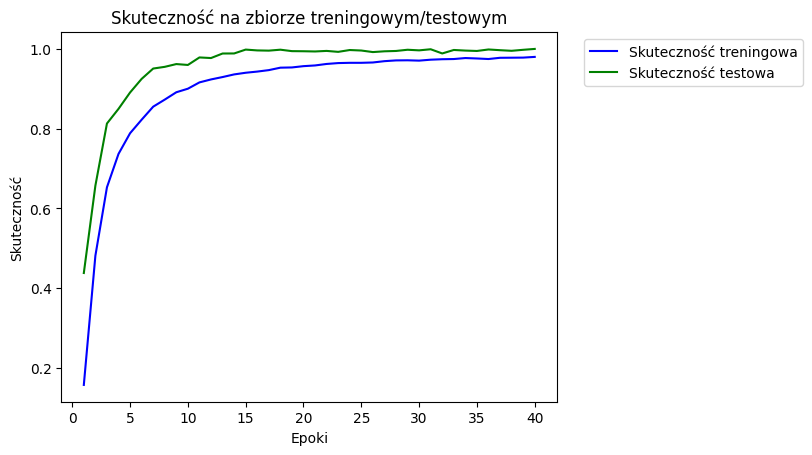

In [39]:
epochs = range(1,41)
plt.plot(epochs, history_final.history['accuracy'], 'b', label='Skuteczność treningowa')
plt.plot(epochs, history_final.history['val_accuracy'], 'g', label='Skuteczność testowa')
plt.title('Skuteczność na zbiorze treningowym/testowym')
plt.xlabel('Epoki')
plt.ylabel('Skuteczność')
plt.legend(bbox_to_anchor=(1.04, 1))
plt.show()

In [40]:
model.save("finalModel.h5")

In [41]:
model = tf.keras.models.load_model("finalModel.h5")

In [42]:
(ls,acc)=model.evaluate(x=X_test,y=y_test)

226/226 [==============================] - 1s 6ms/step - loss: 0.0022 - accuracy: 0.9997


In [43]:
print('Skuteczność modelu na zbiorze testowym = {:.2f}%'.format(acc*100))

Skuteczność modelu na zbiorze testowym = 99.97%


Zastosowane zmiany zbioru treningowego okazały się rozwiązaniem idealnym. Skuteczność na zbiorze treningowym jest minimalnie niższa, a proces uczenia znacznie się wydłużył. Nie mamy jednak doczynienia z overfittingiem, gdyż sieć osiągnęła niemal 100% skuteczności na zbiorze testowym.

#### Sprawdzenie skuteczności na dodatkowym znaku "I Love You"

In [44]:
ily_X_test = X_test[-40:]
ily_y_test = y_test[-40:]

print(ily_X_test.shape, ily_y_test.shape)

(40, 28, 28, 1) (40, 25)


In [45]:
(ls,acc)=model.evaluate(x=ily_X_test,y=ily_y_test)

2/2 [==============================] - 0s 4ms/step - loss: 1.0609e-05 - accuracy: 1.0000


In [46]:
print('Skuteczność modelu na znaku ILY = {:.2f}%'.format(acc*100))

Skuteczność modelu na znaku ILY = 100.00%


Dodatkowo sprawdziliśmy skuteczność sieci jedynie na obrazach dodanych przez nas. Model poprawnie sklasyfikował wszystkie z 40 testowych zdjęć symbolu "I Love You".

### 10. Rozpoznawanie symboli na obrazie z kamery

Ostatnim etapem projektu było przetestowanie działania modelu na rzeczywistym obrazie pochodzącym z laptopa. W tym celu przygotowaliśmy aplikację, która rozpoznaje znaki pokazywane na żywo. Na podglądzie widoku z kamery umieszczone zostało okienko, w którym należy umieścić dłoń. Sieć na bieżąco przetwarza obraz znajdujący się w nim i zwraca rozpoznany symbol.

#### Rozpoznane litery języka migowego na obrazie z kamery:

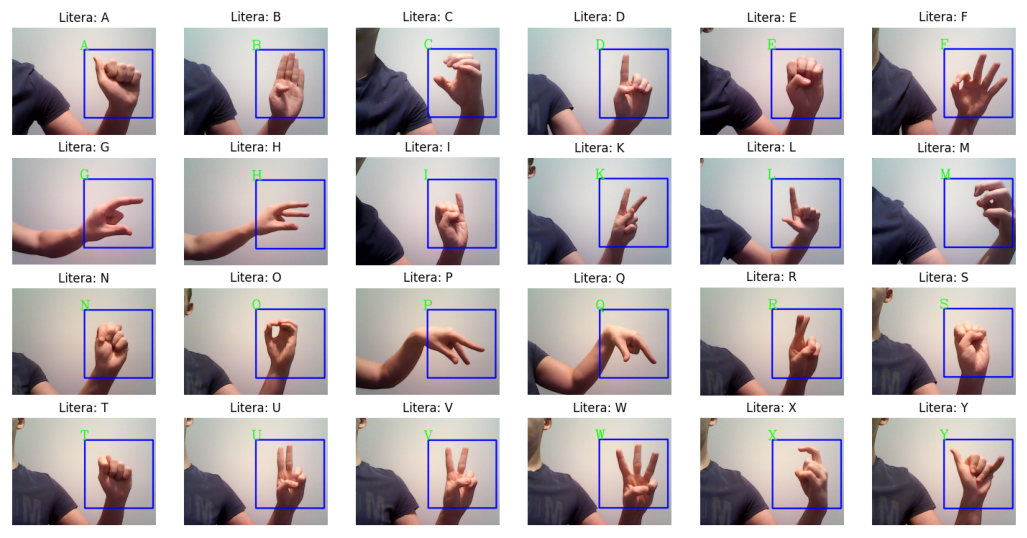

In [43]:
plt.figure(figsize = (13,7))
plt.imshow(img, cmap='gray')
plt.axis('off');

#### Rozpoznanie symbolu "I Love You" na obrazie z kamery:

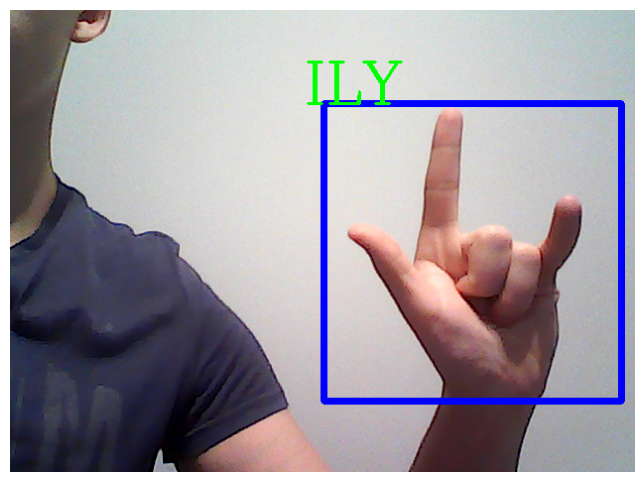

In [45]:
plt.figure(figsize = (12,6))
plt.imshow(img, cmap='gray')
plt.axis('off');

### 11. Wnioski

Podsumowując efekty wykonanej pracy stwierdzamy, że cel projektu został w pełni zrealizowany. Ostateczny model splotowej sieci neuronowej osiągnął niemal bezbłędną skuteczność podczas rozpoznawnia obrazów ze zbioru testowego.

W trakcie przygotowywania algorytmów do klasyfikacji obrazów warto zwrócić uwagę na przewagę głębokich sieci neuronowych, jakimi w tym przypadku są sieci konwolucyjne, nad płytkimi sieciami jednokierunkowymi. Wykorzystany w projekcie model sieci splotowej był skuteczniejszy o 80 punktów procentowych na tym samym zbiorze danych. Sieci płytkie okazały się być bezużyteczne, gdyż ich dokładność jedynie w niewielkim stopniu przewyższyła losowe wybieranie odpowiedzi.

Innym ważnym aspektem podczas tworzenia modeli sztucznej inteligencji jest zadbanie o jak najlepszy zbiór danych. W projekcie pomimo wykonania wielu prób na różnych modelach sieci neuronowych, nie udało się przekroczyć 90 procentowej skuteczności klasyfikatora. Wszystkie przetestowane sieci ulegały nadmiernemu dopasowaniu do danych treningowych, a zbyt duże zwiększenie dropoutu prowadziło do pogorszenia skuteczności. Dopiero wprowadzenie zniekształceń zdjęć treningowych przyniosło oczekiwany efekt w postaci badzo wysokiej skuteczności. Warto zauważyć, że zastosowane modyfikacje zbioru były na tyle skomplikowane, że sieć nie potrafiła w 100% dopasować się do danych treningowych. Nie przeszkodziło to jednak w rozwiązaniu niezedytowanego zbioru testowego.

Rozpoznanie naszego własnego znaku zakończyło się kolejnym sukcesem. Pomimo niewielkiej liczebności przygotowanych danych oraz wysokiej stracie szczegółowości w trakcie zmniejszenia rozmiaru zdjęć, sieć poprawnie sklasyfikowała wszystkie obrazy testowe.

Wykorzystanie przygotowanego modelu do rozpoznawania liter na podstawie obrazu z kamery przyniosło znacznie gorsze efekty. Klasyfikacja liter na żywo jest możliwa jedynie w doskonałych warunkach oświetleniowych oraz na jednolitym, białym tle. W pozostałych przypadkach nie udało uzyskać się zadowalającego efektu. Dobrym pomysłem byłoby zastosowanie przetwarzania obrazu z kamery w celu rozjaśnienia i usunięcie zbędnych elementów tła. Po zapewnieniu dobrej scenerii, sieć była w stanie rozpoznać wszystkie klasy ze zbioru danych, jednak część z nich pokazywała się dopieru po dłuższych próbach. Największe problemy sprawiały litery takiej jak N, S lub T, gdyż pokazuje się je poprzez różne ułożenia zaciśniętej pięści. W trakcie testów bezproblemowe okazało się rozpoznanie dodatkowego symbolu "I Love You", co zachęca do tworzenia zbiorów danych z własnymi obrazami.